# MODELISATION - CHURN PREDICTION FORTUNEO BANQUE

### **Objectif**: Construire et optimiser des modeles de classification pour predire le churn

### **Approche**:
#### 1. Baseline models (Logistic Regression)
#### 2. Modeles avances (RF, XGBoost, LightGBM, CatBoost)
#### 3. Pipelines sklearn
#### 4. Cross-validation
#### 5. Optimisation des hyperparametres
#### 6. Comparaison et selection du meilleur modele


## Importation des library

In [1]:
import os 
os.getcwd()

'/Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/notebooks'

In [3]:
### IMPORTATION DES BIBLIOTHEQUES

# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocessing & Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Sklearn - Model Selection
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

# Sklearn - Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)

# Sklearn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available")

# LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM not available")

# CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("Warning: CatBoost not available")

# Utils
import joblib
import time
from pathlib import Path

In [4]:
# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Bibliotheques importees avec succes!")

Bibliotheques importees avec succes!


## CHARGEMENT DES DONNEES PREPROCESSEES

In [5]:
# Detecter le chemin de base
current_path = Path.cwd()
if current_path.name == 'notebooks':
    base_path = current_path.parent
else:
    base_path = current_path

processed_path = base_path / 'data' / 'processed'

print("="*60)
print("CHARGEMENT DES DONNEES PREPROCESSEES")
print("="*60)

CHARGEMENT DES DONNEES PREPROCESSEES


In [54]:
# Charger les donnees
X_train = pd.read_csv(processed_path / 'X_train.csv')
X_val = pd.read_csv(processed_path / 'X_val.csv')
X_test = pd.read_csv(processed_path / 'X_test.csv')
y_train = pd.read_csv(processed_path / 'y_train.csv')['Exited']
y_val = pd.read_csv(processed_path / 'y_val.csv')['Exited']

print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nDistribution Train:")
print(y_train.value_counts())
print(f"\nDistribution Validation:")
print(y_val.value_counts())


Train set: (132027, 24)
Validation set: (33007, 24)
Test set: (110023, 24)

Distribution Train:
Exited
0    104090
1     27937
Name: count, dtype: int64

Distribution Validation:
Exited
0    26023
1     6984
Name: count, dtype: int64


In [55]:
# Informations sur les features
print(f"\nNombre de features: {X_train.shape[1]}")
print(f"\nListe des features:")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:2d}. {col}")


Nombre de features: 24

Liste des features:
   1. CreditScore
   2. Gender
   3. Age
   4. Tenure
   5. Balance
   6. NumOfProducts
   7. HasCrCard
   8. IsActiveMember
   9. EstimatedSalary
  10. BalanceSalaryRatio
  11. IsZeroBalance
  12. HasMultipleProducts
  13. EngagementScore
  14. Age_Balance_Interaction
  15. TenureAgeRatio
  16. Geography_Germany
  17. Geography_Spain
  18. AgeGroup_Adult
  19. AgeGroup_Middle
  20. AgeGroup_Senior
  21. TenureGroup_Regular
  22. TenureGroup_Loyal
  23. CreditScoreGroup_Good
  24. CreditScoreGroup_Excellent


### FONCTIONS UTILITAIRES

In [56]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    Evalue un modele sur train et validation
    
    Args:
        model: Modele sklearn
        X_train, y_train: Donnees d'entrainement
        X_val, y_val: Donnees de validation
        model_name: Nom du modele
    
    Returns:
        dict avec les metriques
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Probabilites
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Metriques
    results = {
        'model_name': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    return results

In [57]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Affiche la matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Reste (0)', 'Parti (1)'],
                yticklabels=['Reste (0)', 'Parti (1)'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Valeur Reelle')
    plt.xlabel('Valeur Predite')
    plt.tight_layout()
    plt.show()

In [58]:
def plot_roc_curve(y_true, y_proba, model_name="Model"):
    """Affiche la courbe ROC"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Courbe ROC', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [59]:
def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """Affiche l'importance des features"""
    
    # Extraire l'importance selon le type de modele
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Modele ne supporte pas l'importance des features")
        return
    
    # Creer un DataFrame
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Afficher le top N
    top_features = feature_imp.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_imp

In [60]:
def compare_models(results_list):
    """
    Compare les performances de plusieurs modeles
    
    Args:
        results_list: Liste de dictionnaires de resultats
    
    Returns:
        DataFrame de comparaison
    """
    df = pd.DataFrame(results_list)
    
    # Calculer l'overfitting
    df['overfit_accuracy'] = df['train_accuracy'] - df['val_accuracy']
    df['overfit_f1'] = df['train_f1'] - df['val_f1']
    
    return df

### BASELINE MODEL - LOGISTIC REGRESSION

In [61]:
print("="*60)
print("BASELINE MODEL - LOGISTIC REGRESSION")
print("="*60)

BASELINE MODEL - LOGISTIC REGRESSION


In [62]:
# Entrainer le modele baseline
baseline_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
baseline_model

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [63]:
print("\nEntrainement du modele baseline...")
start_time = time.time()
baseline_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Temps d'entrainement: {train_time:.2f} secondes")


Entrainement du modele baseline...
Temps d'entrainement: 0.13 secondes


In [64]:
# Evaluation
baseline_results = evaluate_model(
    baseline_model, X_train, y_train, X_val, y_val,
    model_name="Logistic Regression"
)

print("\n--- RESULTATS BASELINE ---")
print(f"Train Accuracy: {baseline_results['train_accuracy']:.4f}")
print(f"Val Accuracy:   {baseline_results['val_accuracy']:.4f}")
print(f"Train F1:       {baseline_results['train_f1']:.4f}")
print(f"Val F1:         {baseline_results['val_f1']:.4f}")
print(f"Train ROC-AUC:  {baseline_results['train_roc_auc']:.4f}")
print(f"Val ROC-AUC:    {baseline_results['val_roc_auc']:.4f}")


--- RESULTATS BASELINE ---
Train Accuracy: 0.8579
Val Accuracy:   0.8565
Train F1:       0.6083
Val F1:         0.6035
Train ROC-AUC:  0.8745
Val ROC-AUC:    0.8737


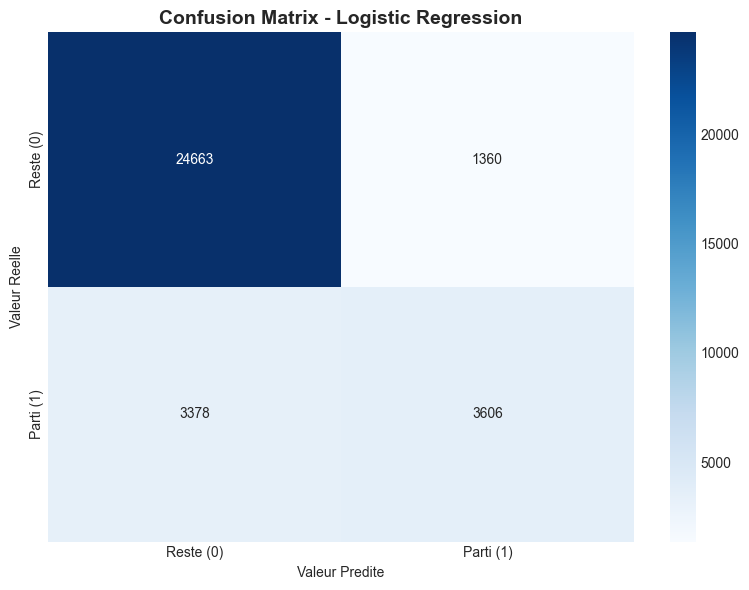

In [65]:
# Matrice de confusion
y_val_pred_baseline = baseline_model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred_baseline, 
                     title="Confusion Matrix - Logistic Regression")

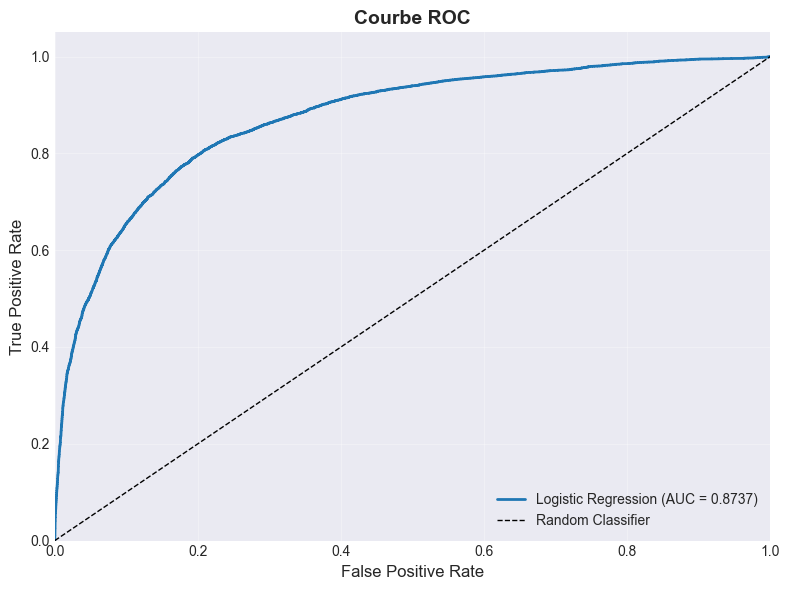

In [66]:
# Courbe ROC
y_val_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]
plot_roc_curve(y_val, y_val_proba_baseline, model_name="Logistic Regression")

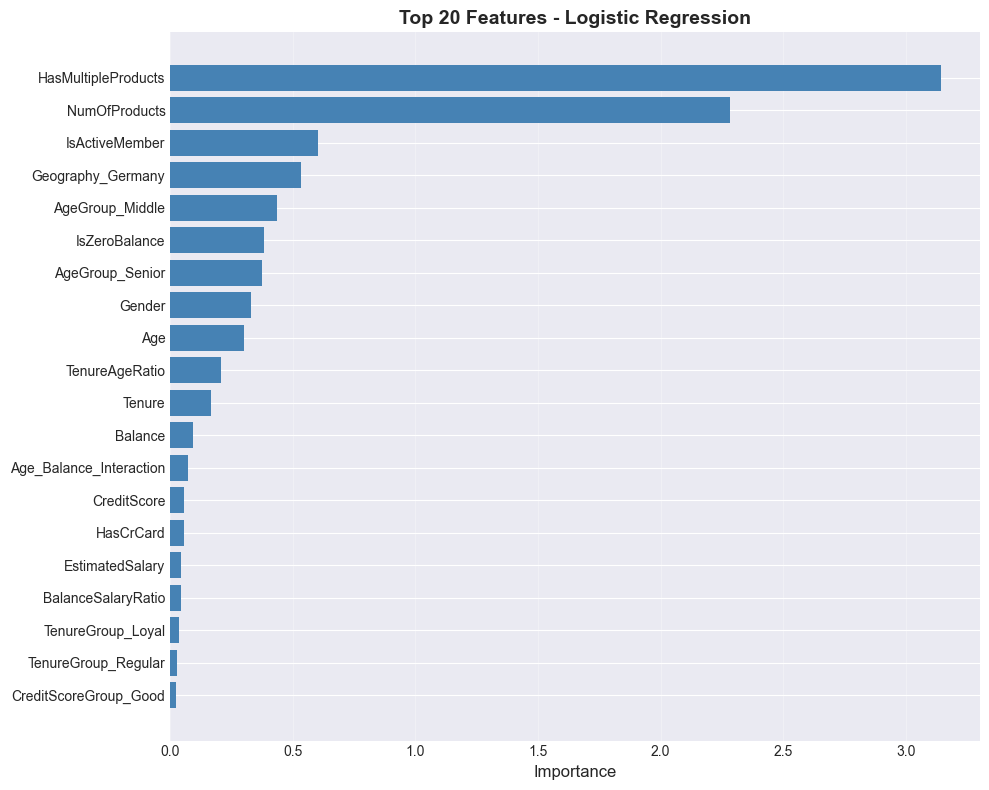


Top 10 Features les plus importantes:


,feature,importance
11,HasMultipleProducts,3.145207
5,NumOfProducts,2.283333
7,IsActiveMember,0.602220
15,Geography_Germany,0.533621
18,AgeGroup_Middle,0.433680
10,IsZeroBalance,0.380559
19,AgeGroup_Senior,0.372675
1,Gender,0.328942
2,Age,0.301624
14,TenureAgeRatio,0.208406


In [67]:
# Feature importance
baseline_feature_imp = plot_feature_importance(
    baseline_model, 
    X_train.columns, 
    top_n=20,
    model_name="Logistic Regression"
)

print("\nTop 10 Features les plus importantes:")
display(baseline_feature_imp.head(10))

### MODELES AVANCES

In [128]:
# Dictionnaire pour stocker tous les resultats
all_results = [baseline_results]
trained_models = {'Logistic Regression': baseline_model}

#### Random Forest

In [129]:
print("="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

RANDOM FOREST CLASSIFIER


In [130]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    class_weight='balanced'
)
rf_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [131]:
print("\nEntrainement du Random Forest...")
start_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Temps d'entrainement: {train_time:.2f} secondes")


Entrainement du Random Forest...
Temps d'entrainement: 1.68 secondes


In [132]:
# Evaluation
rf_results = evaluate_model(
    rf_model, X_train, y_train, X_val, y_val,
    model_name="Random Forest"
)

print("\n--- RESULTATS RANDOM FOREST ---")
print(f"Train Accuracy: {rf_results['train_accuracy']:.4f}")
print(f"Val Accuracy:   {rf_results['val_accuracy']:.4f}")
print(f"Train F1:       {rf_results['train_f1']:.4f}")
print(f"Val F1:         {rf_results['val_f1']:.4f}")
print(f"Train ROC-AUC:  {rf_results['train_roc_auc']:.4f}")
print(f"Val ROC-AUC:    {rf_results['val_roc_auc']:.4f}")


--- RESULTATS RANDOM FOREST ---
Train Accuracy: 0.9058
Val Accuracy:   0.8436
Train F1:       0.7979
Val F1:         0.6523
Train ROC-AUC:  0.9659
Val ROC-AUC:    0.8823


In [133]:
all_results.append(rf_results)
trained_models['Random Forest'] = rf_model

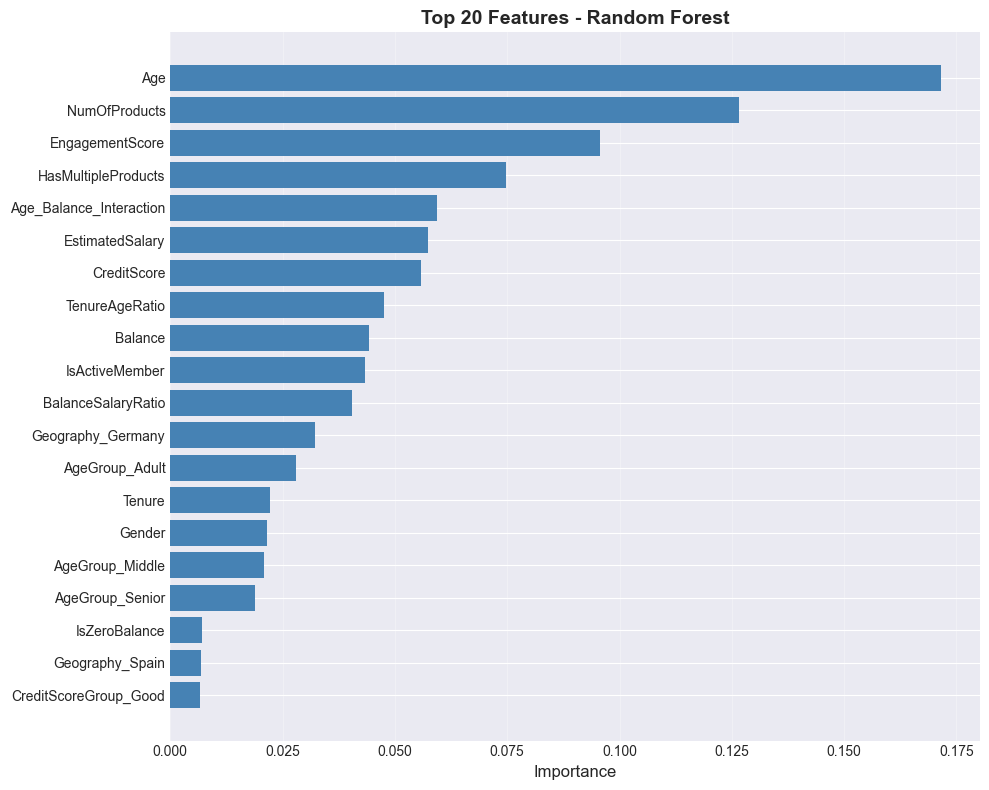

In [134]:
# Feature importance
rf_feature_imp = plot_feature_importance(
    rf_model, 
    X_train.columns, 
    top_n=20,
    model_name="Random Forest"
)

#### Gradient Boosting

In [135]:
print("="*60)
print("GRADIENT BOOSTING CLASSIFIER")
print("="*60)

GRADIENT BOOSTING CLASSIFIER


In [136]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    verbose=0
)
gb_model

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",5
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``,

In [137]:
print("\nEntrainement du Gradient Boosting...")
start_time = time.time()
gb_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"Temps d'entrainement: {train_time:.2f} secondes")


Entrainement du Gradient Boosting...
Temps d'entrainement: 28.83 secondes


In [138]:
# Evaluation
gb_results = evaluate_model(
    gb_model, X_train, y_train, X_val, y_val,
    model_name="Gradient Boosting"
)

print("\n--- RESULTATS GRADIENT BOOSTING ---")
print(f"Train Accuracy: {gb_results['train_accuracy']:.4f}")
print(f"Val Accuracy:   {gb_results['val_accuracy']:.4f}")
print(f"Train F1:       {gb_results['train_f1']:.4f}")
print(f"Val F1:         {gb_results['val_f1']:.4f}")
print(f"Train ROC-AUC:  {gb_results['train_roc_auc']:.4f}")
print(f"Val ROC-AUC:    {gb_results['val_roc_auc']:.4f}")

all_results.append(gb_results)
trained_models['Gradient Boosting'] = gb_model


--- RESULTATS GRADIENT BOOSTING ---
Train Accuracy: 0.8702
Val Accuracy:   0.8654
Train F1:       0.6500
Val F1:         0.6357
Train ROC-AUC:  0.8958
Val ROC-AUC:    0.8893


#### XGBoost

XGBOOST CLASSIFIER

Entrainement de XGBoost...
Temps d'entrainement: 0.37 secondes

--- RESULTATS XGBOOST ---
Train Accuracy: 0.8720
Val Accuracy:   0.8662
Train F1:       0.6536
Val F1:         0.6368
Train ROC-AUC:  0.9003
Val ROC-AUC:    0.8891


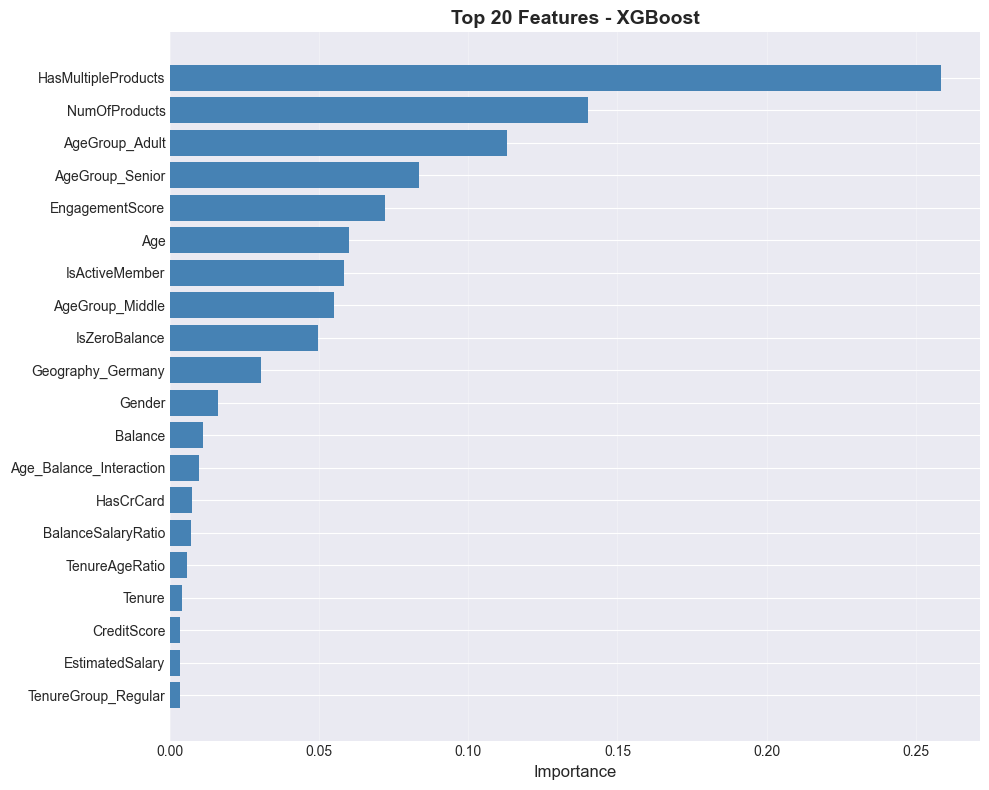

In [139]:
if XGBOOST_AVAILABLE:
    print("="*60)
    print("XGBOOST CLASSIFIER")
    print("="*60)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        class_weight='balanced'
    )
    
    print("\nEntrainement de XGBoost...")
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    xgb_results = evaluate_model(
        xgb_model, X_train, y_train, X_val, y_val,
        model_name="XGBoost"
    )
    
    print("\n--- RESULTATS XGBOOST ---")
    print(f"Train Accuracy: {xgb_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {xgb_results['val_accuracy']:.4f}")
    print(f"Train F1:       {xgb_results['train_f1']:.4f}")
    print(f"Val F1:         {xgb_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {xgb_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {xgb_results['val_roc_auc']:.4f}")
    
    all_results.append(xgb_results)
    trained_models['XGBoost'] = xgb_model
    
    # Feature importance
    xgb_feature_imp = plot_feature_importance(
        xgb_model, 
        X_train.columns, 
        top_n=20,
        model_name="XGBoost"
    )
else:
    print("XGBoost non disponible. Installation: pip install xgboost")

XGBOOST CLASSIFIER

Entrainement de XGBoost...
Temps d'entrainement: 0.34 secondes

--- RESULTATS XGBOOST ---
Train Accuracy: 0.8835
Val Accuracy:   0.8634
Train F1:       0.6876
Val F1:         0.6312
Train ROC-AUC:  0.9176
Val ROC-AUC:    0.8861


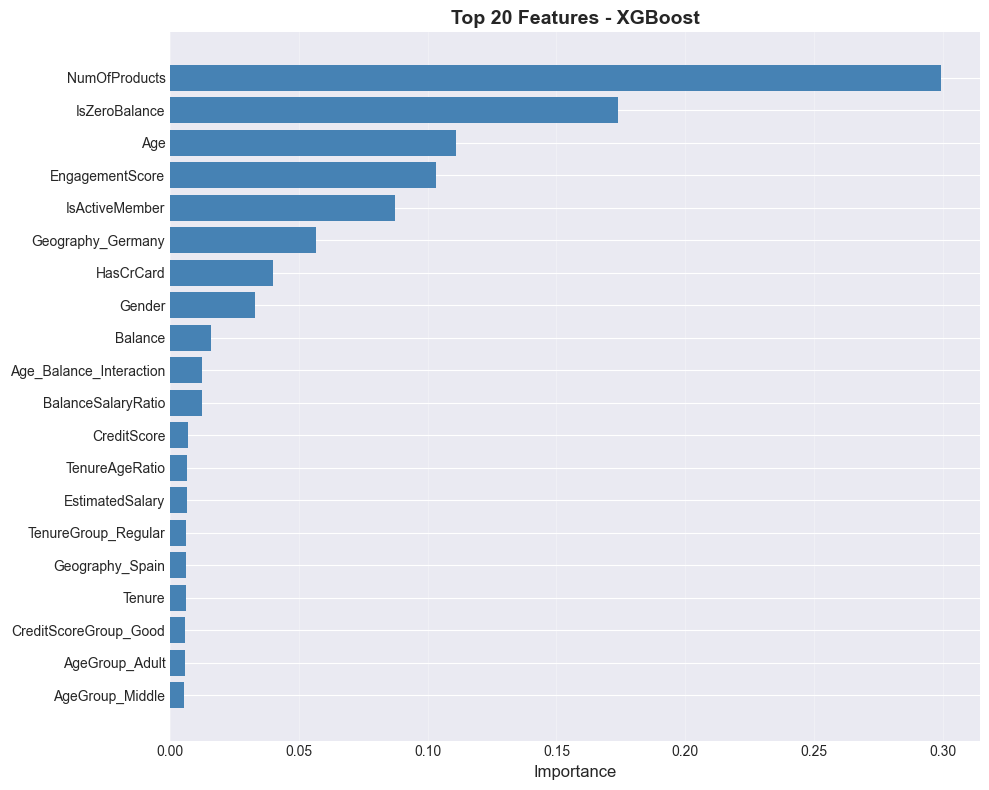

In [140]:
if XGBOOST_AVAILABLE:
    print("="*60)
    print("XGBOOST CLASSIFIER")
    print("="*60)
    
    xgb_model = xgb.XGBClassifier()
    
    print("\nEntrainement de XGBoost...")
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    xgb_results = evaluate_model(
        xgb_model, X_train, y_train, X_val, y_val,
        model_name="XGBoost"
    )
    
    print("\n--- RESULTATS XGBOOST ---")
    print(f"Train Accuracy: {xgb_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {xgb_results['val_accuracy']:.4f}")
    print(f"Train F1:       {xgb_results['train_f1']:.4f}")
    print(f"Val F1:         {xgb_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {xgb_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {xgb_results['val_roc_auc']:.4f}")
    
    all_results.append(xgb_results)
    trained_models['XGBoost'] = xgb_model
    
    # Feature importance
    xgb_feature_imp = plot_feature_importance(
        xgb_model, 
        X_train.columns, 
        top_n=20,
        model_name="XGBoost"
    )
else:
    print("XGBoost non disponible. Installation: pip install xgboost")

#### LightGBM

LIGHTGBM CLASSIFIER

Entrainement de LightGBM...
Temps d'entrainement: 0.87 secondes

--- RESULTATS LIGHTGBM ---
Train Accuracy: 0.8210
Val Accuracy:   0.8179
Train F1:       0.6549
Val F1:         0.6471
Train ROC-AUC:  0.8973
Val ROC-AUC:    0.8894


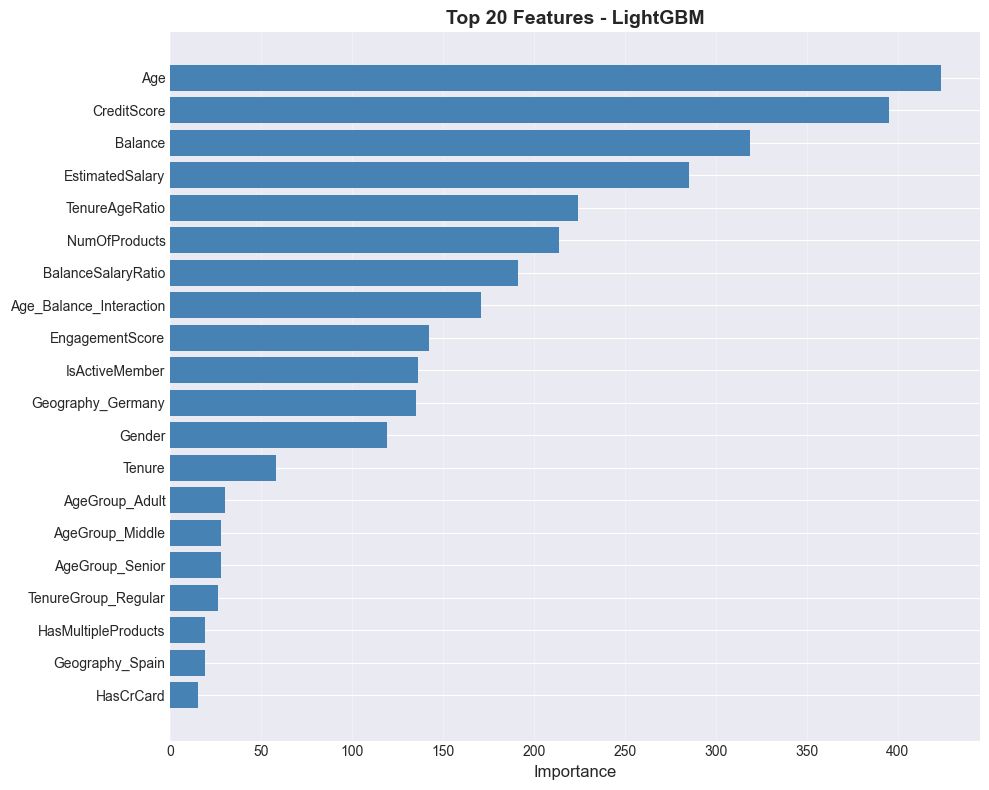

In [141]:
if LIGHTGBM_AVAILABLE:
    print("="*60)
    print("LIGHTGBM CLASSIFIER")
    print("="*60)
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        class_weight='balanced'
    )
    
    print("\nEntrainement de LightGBM...")
    start_time = time.time()
    lgb_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    lgb_results = evaluate_model(
        lgb_model, X_train, y_train, X_val, y_val,
        model_name="LightGBM"
    )
    
    print("\n--- RESULTATS LIGHTGBM ---")
    print(f"Train Accuracy: {lgb_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {lgb_results['val_accuracy']:.4f}")
    print(f"Train F1:       {lgb_results['train_f1']:.4f}")
    print(f"Val F1:         {lgb_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {lgb_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {lgb_results['val_roc_auc']:.4f}")
    
    all_results.append(lgb_results)
    trained_models['LightGBM'] = lgb_model
    
    # Feature importance
    lgb_feature_imp = plot_feature_importance(
        lgb_model, 
        X_train.columns, 
        top_n=20,
        model_name="LightGBM"
    )
else:
    print("LightGBM non disponible. Installation: pip install lightgbm")

#### CatBoost

CATBOOST CLASSIFIER

Entrainement de CatBoost...
Temps d'entrainement: 0.94 secondes

--- RESULTATS CATBOOST ---
Train Accuracy: 0.8666
Val Accuracy:   0.8652
Train F1:       0.6331
Val F1:         0.6279
Train ROC-AUC:  0.8916
Val ROC-AUC:    0.8891


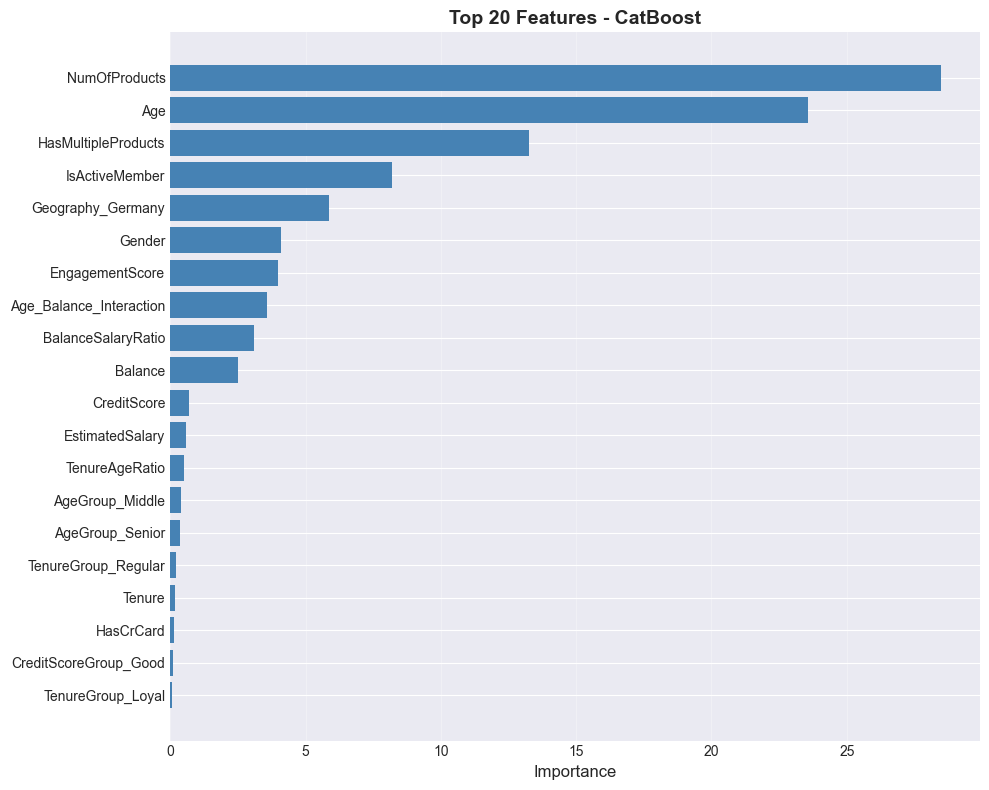

In [142]:
if CATBOOST_AVAILABLE:
    print("="*60)
    print("CATBOOST CLASSIFIER")
    print("="*60)
    
    cat_model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=3,
        random_state=42,
        verbose=0
    )
    
    print("\nEntrainement de CatBoost...")
    start_time = time.time()
    cat_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Temps d'entrainement: {train_time:.2f} secondes")
    
    # Evaluation
    cat_results = evaluate_model(
        cat_model, X_train, y_train, X_val, y_val,
        model_name="CatBoost"
    )
    
    print("\n--- RESULTATS CATBOOST ---")
    print(f"Train Accuracy: {cat_results['train_accuracy']:.4f}")
    print(f"Val Accuracy:   {cat_results['val_accuracy']:.4f}")
    print(f"Train F1:       {cat_results['train_f1']:.4f}")
    print(f"Val F1:         {cat_results['val_f1']:.4f}")
    print(f"Train ROC-AUC:  {cat_results['train_roc_auc']:.4f}")
    print(f"Val ROC-AUC:    {cat_results['val_roc_auc']:.4f}")
    
    all_results.append(cat_results)
    trained_models['CatBoost'] = cat_model
    
    # Feature importance
    cat_feature_imp = plot_feature_importance(
        cat_model, 
        X_train.columns, 
        top_n=20,
        model_name="CatBoost"
    )
else:
    print("CatBoost non disponible. Installation: pip install catboost")

### COMPARAISON DES MODELES

In [143]:
print("="*60)
print("COMPARAISON DES MODELES")
print("="*60)

COMPARAISON DES MODELES


In [144]:
# Creer le DataFrame de comparaison
comparison_df = compare_models(all_results)

# Trier par validation ROC-AUC
comparison_df = comparison_df.sort_values('val_roc_auc', ascending=False)

print("\nTableau de comparaison complet:")
display(comparison_df)


Tableau de comparaison complet:


,model_name,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc,overfit_accuracy,overfit_f1
5,LightGBM,0.820961,0.817857,0.553005,0.548358,0.802735,0.789089,0.654869,0.647059,0.897288,0.889429,0.003104,0.007811
2,Gradient Boosting,0.870155,0.865422,0.756438,0.744048,0.569854,0.554840,0.650021,0.635663,0.895763,0.889285,0.004733,0.014359
6,CatBoost,0.866580,0.865241,0.757048,0.755131,0.544081,0.537371,0.633135,0.627907,0.891643,0.889069,0.001340,0.005229
3,XGBoost,0.871996,0.866240,0.764689,0.748309,0.570677,0.554267,0.653589,0.636835,0.900315,0.889062,0.005755,0.016754
4,XGBoost,0.883531,0.863423,0.794946,0.736350,0.605863,0.552262,0.687643,0.631157,0.917582,0.886054,0.020108,0.056487
1,Random Forest,0.905837,0.843609,0.730970,0.615844,0.878226,0.693442,0.797860,0.652344,0.965873,0.882343,0.062229,0.145516
0,Logistic Regression,0.857893,0.856455,0.729777,0.726138,0.521531,0.516323,0.608325,0.603515,0.874516,0.873657,0.001438,0.004811


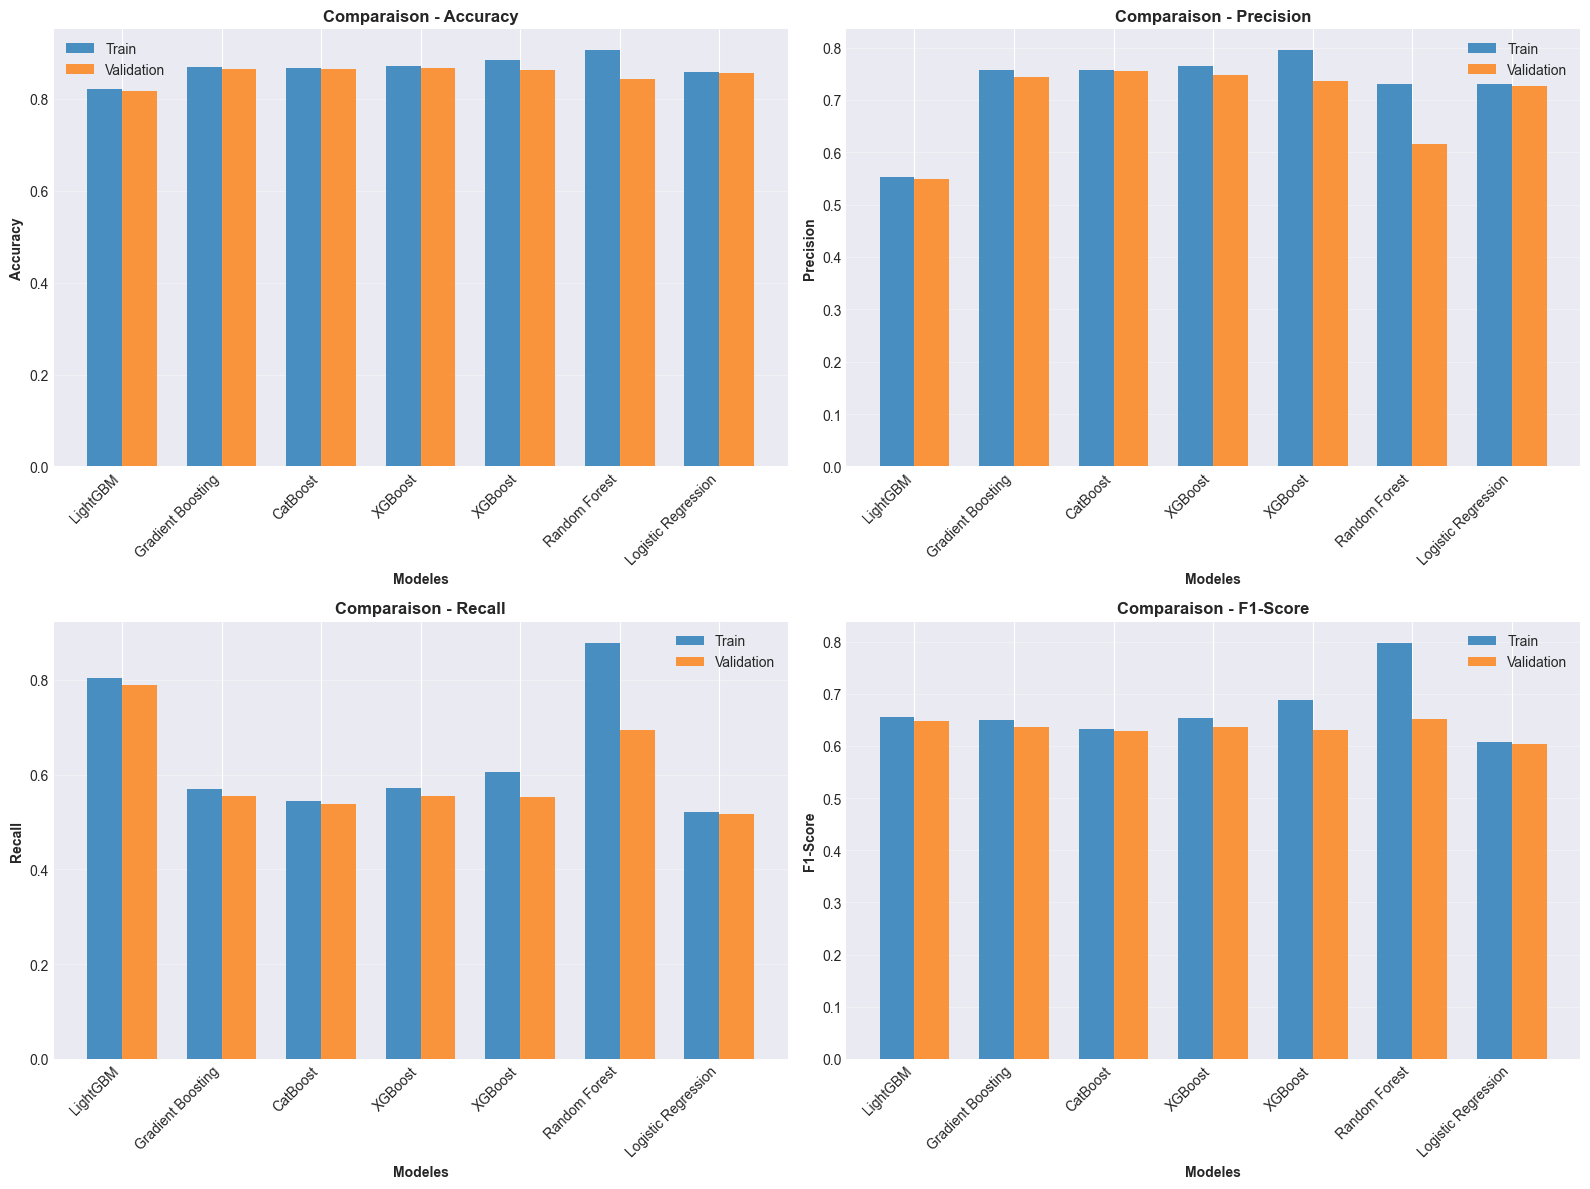

In [145]:
# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    train_col = f'train_{metric}'
    val_col = f'val_{metric}'
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df[train_col], width, 
                   label='Train', alpha=0.8)
    bars2 = ax.bar(x + width/2, comparison_df[val_col], width, 
                   label='Validation', alpha=0.8)
    
    ax.set_xlabel('Modeles', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_title(f'Comparaison - {title}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['model_name'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

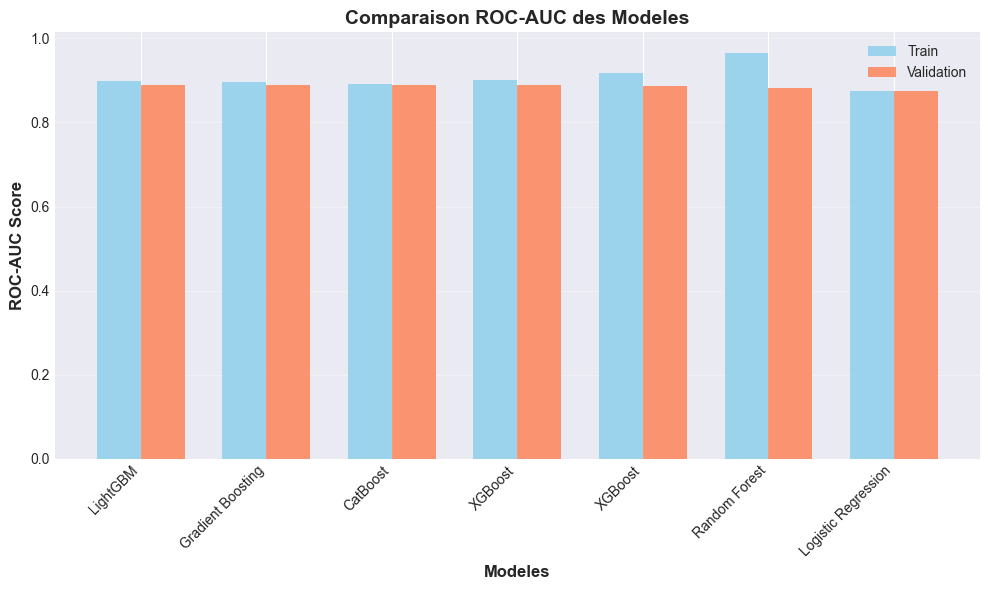

In [146]:
# Visualisation ROC-AUC
plt.figure(figsize=(10, 6))

train_roc = comparison_df['train_roc_auc']
val_roc = comparison_df['val_roc_auc']
models = comparison_df['model_name']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_roc, width, label='Train', alpha=0.8, color='skyblue')
plt.bar(x + width/2, val_roc, width, label='Validation', alpha=0.8, color='coral')

plt.xlabel('Modeles', fontweight='bold', fontsize=12)
plt.ylabel('ROC-AUC Score', fontweight='bold', fontsize=12)
plt.title('Comparaison ROC-AUC des Modeles', fontsize=14, fontweight='bold')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [194]:
# Identifier le meilleur modele
best_model_name = comparison_df.iloc[0]['model_name']
best_model = trained_models[best_model_name]

print("="*60)
print(f"MEILLEUR MODELE: {best_model_name}")
print("="*60)

best_results = comparison_df.iloc[0]
print(f"\nValidation Accuracy:  {best_results['val_accuracy']:.4f}")
print(f"Validation Precision: {best_results['val_precision']:.4f}")
print(f"Validation Recall:    {best_results['val_recall']:.4f}")
print(f"Validation F1-Score:  {best_results['val_f1']:.4f}")
print(f"Validation ROC-AUC:   {best_results['val_roc_auc']:.4f}")

MEILLEUR MODELE: LightGBM

Validation Accuracy:  0.8179
Validation Precision: 0.5484
Validation Recall:    0.7891
Validation F1-Score:  0.6471
Validation ROC-AUC:   0.8894


### EVALUATION FINALE DU MEILLEUR MODELE

In [195]:
print("="*60)
print(f"OPTIMISATION DES HYPERPARAMETRES - {best_model_name}")
print("="*60)

OPTIMISATION DES HYPERPARAMETRES - LightGBM


#### RandomSearch

In [196]:
# Definir les grilles de parametres selon le modele
if best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
    
elif best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 4, 6]
    }
    
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [10, 20, 30]
    }
    
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [300, 500, 700],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 7, 11],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9]
    }
    
elif best_model_name == "LightGBM":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 7, 10],
        'num_leaves': [31, 50, 70],
        'min_child_samples': [10, 20, 30],
        'class_weight': ['balanced']
    }
    
elif best_model_name == "CatBoost":
    param_grid = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5]
    }
else:
    param_grid = {}

In [197]:
# Nous utilisons RandomizedSearchCV pour une optimisation plus rapide
if param_grid:
    print(f"\nRecherche des meilleurs hyperparametres...")
    print(f"Grille de parametres: {len(param_grid)} parametres")
    
    # Creer un nouveau modele
    if best_model_name == "Logistic Regression":
        base_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    elif best_model_name == "Random Forest":
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif best_model_name == "Gradient Boosting":
        base_model = GradientBoostingClassifier(random_state=42)
    elif best_model_name == "XGBoost":
        base_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
    elif best_model_name == "LightGBM":
        base_model = lgb.LGBMClassifier(random_state=42)
    elif best_model_name == "CatBoost":
        base_model = CatBoostClassifier(random_state=42, verbose=0)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    print("\nDemarrage de l'optimisation...")
    start_time = time.time()
    random_search.fit(X_train, y_train)
    optimization_time = time.time() - start_time
    
    print(f"\nTemps d'optimisation: {optimization_time:.2f} secondes")
    print(f"\nMeilleurs parametres trouves:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    # Modele optimise
    optimized_model = random_search.best_estimator_
    
    # Evaluation du modele optimise
    optimized_results = evaluate_model(
        optimized_model, X_train, y_train, X_val, y_val,
        model_name=f"{best_model_name} (Optimized)"
    )
    
    print("\n--- RESULTATS APRES OPTIMISATION ---")
    print(f"Val Accuracy:  {optimized_results['val_accuracy']:.4f} (avant: {best_results['val_accuracy']:.4f})")
    print(f"Val Precision: {optimized_results['val_precision']:.4f} (avant: {best_results['val_precision']:.4f})")
    print(f"Val Recall:    {optimized_results['val_recall']:.4f} (avant: {best_results['val_recall']:.4f})")
    print(f"Val F1-Score:  {optimized_results['val_f1']:.4f} (avant: {best_results['val_f1']:.4f})")
    print(f"Val ROC-AUC:   {optimized_results['val_roc_auc']:.4f} (avant: {best_results['val_roc_auc']:.4f})")
    
    # Comparer avant/apres
    improvement = {
        'Accuracy': optimized_results['val_accuracy'] - best_results['val_accuracy'],
        'Precision': optimized_results['val_precision'] - best_results['val_precision'],
        'Recall': optimized_results['val_recall'] - best_results['val_recall'],
        'F1-Score': optimized_results['val_f1'] - best_results['val_f1'],
        'ROC-AUC': optimized_results['val_roc_auc'] - best_results['val_roc_auc']
    }
    
    print("\n--- AMELIORATION ---")
    for metric, value in improvement.items():
        sign = "+" if value >= 0 else ""
        print(f"{metric:12s}: {sign}{value:.4f}")
    
    # Utiliser le modele optimise si meilleur
    if optimized_results['val_roc_auc'] > best_results['val_roc_auc']:
        best_model = optimized_model
        print(f"\nModele optimise retenu (ROC-AUC ameliore)")
    else:
        print(f"\nModele original retenu (pas d'amelioration)")
else:
    print("Pas de grille de parametres definie pour ce modele")
    optimized_model = best_model


Recherche des meilleurs hyperparametres...
Grille de parametres: 6 parametres

Demarrage de l'optimisation...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 18624, number of negative: 69394
[LightGBM] [Info] Number of positive: 18624, number of negative: 69394
[LightGBM] [Info] Number of positive: 18624, number of negative: 69394
[LightGBM] [Info] Number of positive: 18625, number of negative: 69393
[LightGBM] [Info] Number of positive: 18625, number of negative: 69393
[LightGBM] [Info] Number of positive: 18625, number of negative: 69393
[LightGBM] [Info] Number of positive: 18625, number of negative: 69393
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of positive: 18625, number of negative: 69393


### EVALUATION FINALE DU MEILLEUR MODELE

In [ ]:
# Identifier le meilleur modele
best_model_name = comparison_df.iloc[0]['model_name']
best_model = trained_models[best_model_name]

print("="*60)
print(f"MEILLEUR MODELE: {best_model_name}")
print("="*60)

best_results = comparison_df.iloc[0]
print(f"\nValidation Accuracy:  {best_results['val_accuracy']:.4f}")
print(f"Validation Precision: {best_results['val_precision']:.4f}")
print(f"Validation Recall:    {best_results['val_recall']:.4f}")
print(f"Validation F1-Score:  {best_results['val_f1']:.4f}")
print(f"Validation ROC-AUC:   {best_results['val_roc_auc']:.4f}")

In [176]:
print("="*60)
print("EVALUATION FINALE DU MEILLEUR MODELE")
print("="*60)

EVALUATION FINALE DU MEILLEUR MODELE


In [199]:
# Predictions sur validation
y_val_pred_final = best_model.predict(X_val)
y_val_proba_final = best_model.predict_proba(X_val)[:, 1]
y_val_pred_final
y_val_proba_final

array([0.20849472, 0.86097184, 0.06277493, ..., 0.1610731 , 0.02105297,
       0.10294633], shape=(33007,))

In [200]:
# Rapport de classification complet
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_val, y_val_pred_final, 
                          target_names=['Reste (0)', 'Parti (1)']))


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

   Reste (0)       0.94      0.83      0.88     26023
   Parti (1)       0.55      0.79      0.65      6984

    accuracy                           0.82     33007
   macro avg       0.74      0.81      0.76     33007
weighted avg       0.85      0.82      0.83     33007



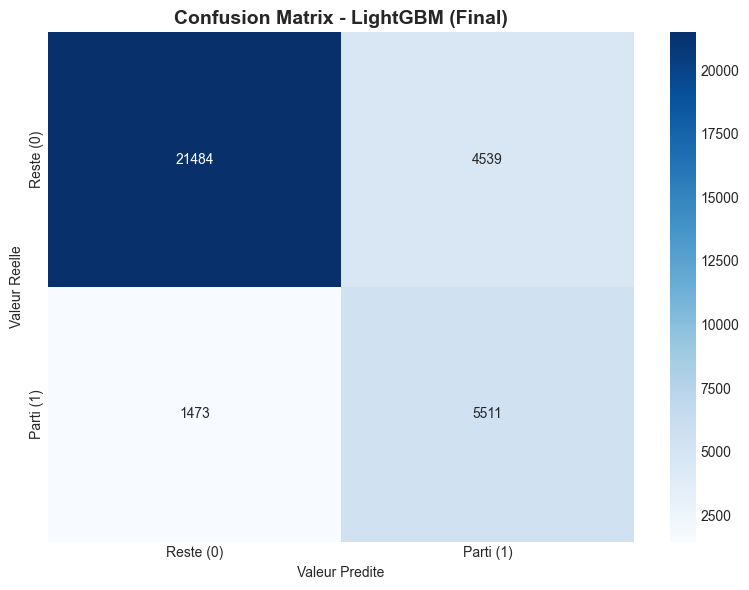

In [201]:
# Matrice de confusion finale
plot_confusion_matrix(y_val, y_val_pred_final, 
                     title=f"Confusion Matrix - {best_model_name} (Final)")

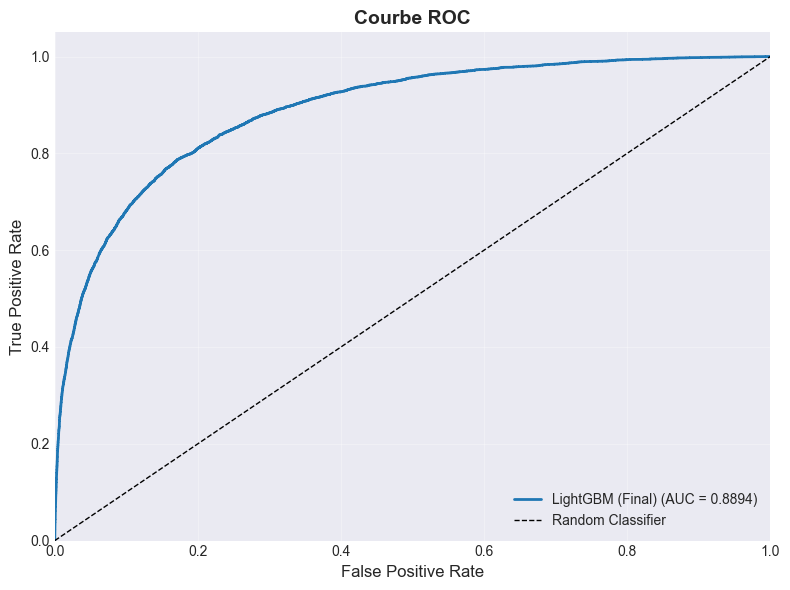

In [202]:
# Courbe ROC finale
plot_roc_curve(y_val, y_val_proba_final, 
              model_name=f"{best_model_name} (Final)")

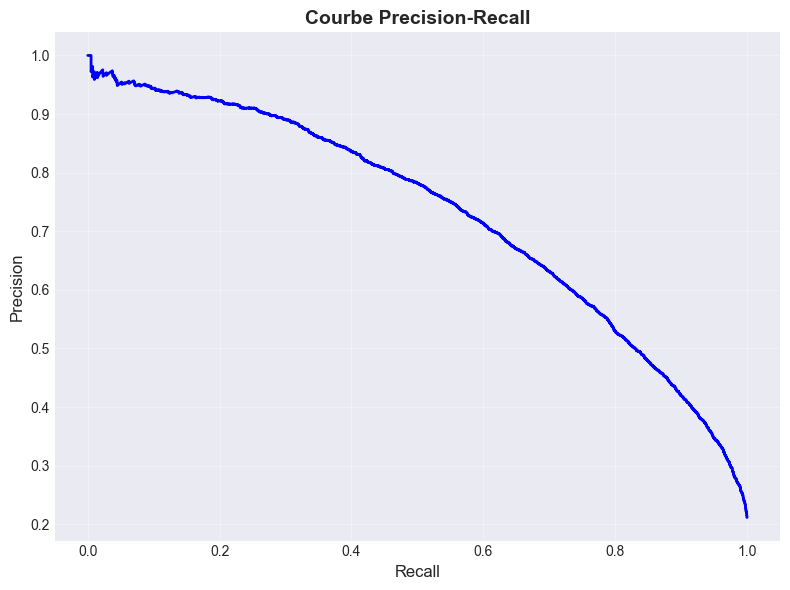

In [203]:
# Courbe Precision-Recall
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_val_proba_final)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, linewidth=2, color='blue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Courbe Precision-Recall', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

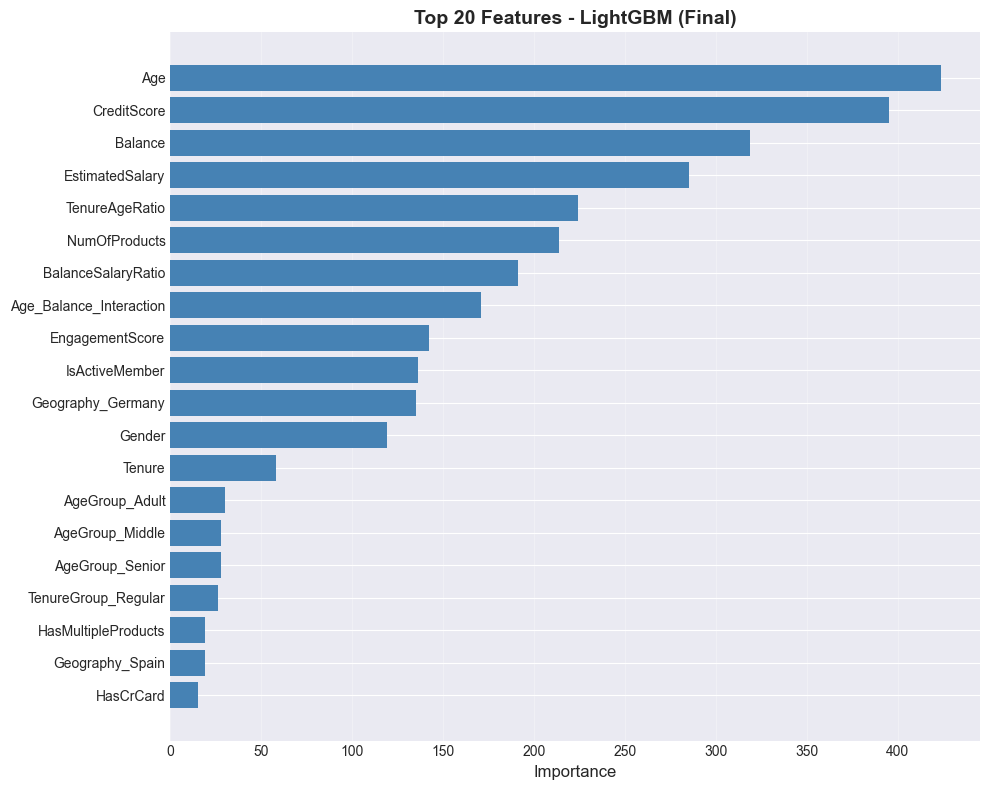


Top 15 Features les plus importantes:


,feature,importance
2,Age,424
0,CreditScore,395
4,Balance,319
8,EstimatedSalary,285
14,TenureAgeRatio,224
5,NumOfProducts,214
9,BalanceSalaryRatio,191
13,Age_Balance_Interaction,171
12,EngagementScore,142
7,IsActiveMember,136


In [204]:
# Feature importance finale
if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
    final_feature_imp = plot_feature_importance(
        best_model, 
        X_train.columns, 
        top_n=20,
        model_name=f"{best_model_name} (Final)"
    )
    
    print("\nTop 15 Features les plus importantes:")
    display(final_feature_imp.head(15))

### Visualisation du seuil optimal

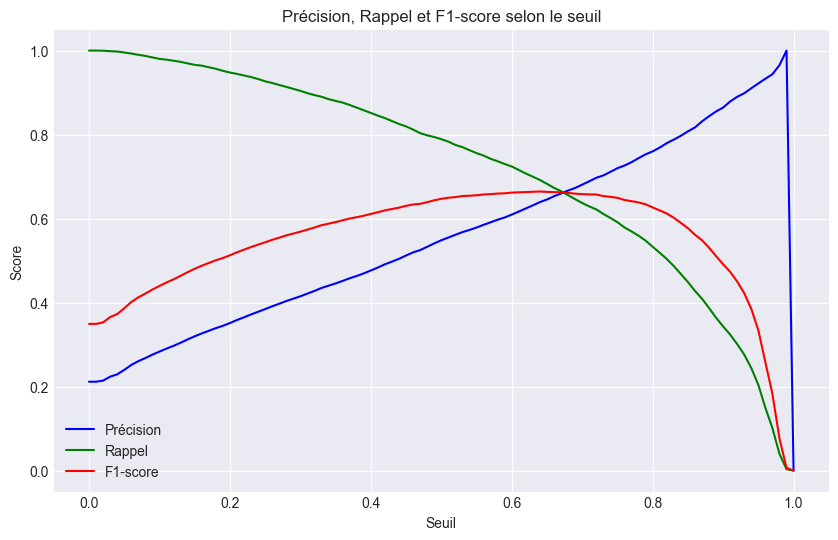

In [ ]:
# définir les seuils à tester
thresholds = np.linspace(0, 1, 101)
y_val_proba = best_model.predict_proba(X_val)[:, 1]


# Listes pour stocker les métriques
precisions = []
recalls = []
f1_scores = []

# Calcul des métriques pour chaque seuil
for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

# Tracé
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label="Précision", color="blue")
plt.plot(thresholds, recalls, label="Rappel", color="green")
plt.plot(thresholds, f1_scores, label="F1-score", color="red")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("Précision, Rappel et F1-score selon le seuil")
plt.legend()
plt.grid(True)
plt.show()

### SAUVEGARDE DU MODELE FINAL

In [205]:
print("="*60)
print("SAUVEGARDE DU MODELE FINAL")
print("="*60)

SAUVEGARDE DU MODELE FINAL


In [207]:
# Creer le dossier models s'il n'existe pas
models_path = base_path / 'models' / 'saved_models'
models_path.mkdir(parents=True, exist_ok=True)

In [208]:
# Nom du fichier
model_filename = f"best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
model_path = models_path / model_filename

In [209]:
# Sauvegarder le modele
joblib.dump(best_model, model_path)
print(f"\nModele sauvegarde: {model_path}")


Modele sauvegarde: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/best_model_lightgbm.pkl


In [210]:
# Sauvegarder aussi les resultats
results_filename = f"model_results_{best_model_name.lower().replace(' ', '_')}.pkl"
results_path = models_path / results_filename

results_to_save = {
    'model_name': best_model_name,
    'best_params': random_search.best_params_ if 'random_search' in locals() else None,
    'validation_metrics': optimized_results if 'optimized_results' in locals() else best_results,
    'feature_importance': final_feature_imp if 'final_feature_imp' in locals() else None,
    'all_models_comparison': comparison_df
}

joblib.dump(results_to_save, results_path)
print(f"Resultats sauvegardes: {results_path}")

Resultats sauvegardes: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/model_results_lightgbm.pkl


In [211]:
# Sauvegarder aussi les comparaisons
comparison_df.to_csv(models_path / 'models_comparison.csv', index=False)
print(f"Comparaison sauvegardee: {models_path / 'models_comparison.csv'}")

Comparaison sauvegardee: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/models_comparison.csv


### RESUME FINAL

In [212]:
print("="*80)
print("RESUME FINAL DU PROJET")
print("="*80)

RESUME FINAL DU PROJET


In [213]:
print(f"""
MODELE SELECTIONNE: {best_model_name}

PERFORMANCES SUR VALIDATION:
  - Accuracy:  {best_results['val_accuracy']:.4f}
  - Precision: {best_results['val_precision']:.4f}
  - Recall:    {best_results['val_recall']:.4f}
  - F1-Score:  {best_results['val_f1']:.4f}
  - ROC-AUC:   {best_results['val_roc_auc']:.4f}



NOMBRE DE MODELES TESTES: {len(all_results)}

FICHIERS SAUVEGARDES:
  - Modele: {model_path}
  - Resultats: {results_path}
  - Comparaison: {models_path / 'models_comparison.csv'}

PROCHAINES ETAPES:
  1. Tester sur le test set
  2. Analyser les erreurs de prediction
  3. Deploiement du modele
  4. Monitoring en production
""")


MODELE SELECTIONNE: LightGBM

PERFORMANCES SUR VALIDATION:
  - Accuracy:  0.8179
  - Precision: 0.5484
  - Recall:    0.7891
  - F1-Score:  0.6471
  - ROC-AUC:   0.8894



NOMBRE DE MODELES TESTES: 7

FICHIERS SAUVEGARDES:
  - Modele: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/best_model_lightgbm.pkl
  - Resultats: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/model_results_lightgbm.pkl
  - Comparaison: /Users/Apple/Desktop/Projets/machine_learning/Projet-Machine-Learning-No2/models/saved_models/models_comparison.csv

PROCHAINES ETAPES:
  1. Tester sur le test set
  2. Analyser les erreurs de prediction
  3. Deploiement du modele
  4. Monitoring en production



In [214]:
print("="*80)
print("MODELISATION TERMINEE AVEC SUCCES!")
print("="*80)

MODELISATION TERMINEE AVEC SUCCES!
